## This version Simulates IA on a Logrithmic Scale
#### Features
- General density and angular distributions are enabled
- Density Profile Tracking enabled
- Different built-in sampling methods enabled

#### Deprecation
- R_cut deprecated: everything radial should be normalized before input
- 3D-catalogue-building(All_Sats) deprecated
- All_Sats_2D deprecated, merged into the vector Proj_Data to conserve disk space

#### run_folder name standard (the master folder of each condition's run is called outputpath):
- 'mod n n baR baR smr smr' etc... the second instance is the actual number. seperated by nothing but space

### Modules

In [1]:
%%writefile ia_geometry_func.py
def Cart_to_Sph(xyz): #input np array [[x,y,z]], output[[r,theta,phi]]
    import numpy as np
    ptsnew = np.zeros(xyz.shape)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew
#pts = np.array([[1,1,1]])
#print(Cart_to_Sph(pts))
#[[r,theta,phi]] = Cart_to_Sph(np.array([[1,1,1]]))
#print(r)#print(theta)#print(phi)

def Cart_to_Polar(xy): #input np array [[x,y]], output[[r,phi]]
    import numpy as np
    ptsnew = np.zeros(xy.shape)
#    ptsnew = np.zeros((1,2))
    ptsnew[:,0] = np.sqrt(xy[:,0]**2+xy[:,1]**2)
    ptsnew[:,1] = np.arctan2(xy[:,1], xy[:,0]) #for elevation angle defined from Z-axis down
    return ptsnew

def Sph_to_Cart(xyz): #input np array [[r,theta,phi]], output[[x,y,z]]
    import numpy as np
    ptsnew = np.zeros(xyz.shape)
#    ptsnew = np.zeros((1,3))
    ptsnew[:,0] = xyz[:,0]*np.sin(xyz[:,1])*np.cos(xyz[:,2])
    ptsnew[:,1] = xyz[:,0]*np.sin(xyz[:,1])*np.sin(xyz[:,2])
    ptsnew[:,2] = xyz[:,0]*np.cos(xyz[:,1])
    return ptsnew
#Cartesian_np(np.array([[1.73205081, 0.95531662, 0.78539816]]))
#pts = np.array([[1,1,1]])
#Cartesian_np(Cart_to_Sph(pts))

def Polar_to_Cart(xy): #input np array [[r,phi]], output[[x,y]]
    import numpy as np
#    ptsnew = np.zeros((1,2))
    ptsnew = np.zeros(xy.shape)
    ptsnew[:,0] = xy[:,0]*np.cos(xy[:,1])
    ptsnew[:,1] = xy[:,0]*np.sin(xy[:,1])
    return ptsnew
#print(Cart_to_Polar(np.array([[-1,0]])))
#np.array([[1,1,1]]).shape

def Ellip_proj_mag(baR_mag,local_theta): # calculates the projected baR ratio
    import numpy as np
    #arctan2 takes (y,x)
    temp = np.arctan(baR_mag/np.tan(local_theta))
    #baR_mag/(np.sin(local_theta)*np.cos(temp)+baR_mag*np.cos(local_theta)*np.sin(temp))
    return baR_mag/(np.sin(local_theta)*np.cos(temp)+baR_mag*np.cos(local_theta)*np.sin(temp))

def Cart_to_eps(sat_state): 
    #input is a length 4 np.array, in cartesian coord, [[sat_location_x, sat_location_y,sat_orient_x,sat_orient_y]], output eps+
    import numpy as np
    sat_state_loc = sat_state[:,0:2] #[sat_location_x, sat_location_y]
    sat_state_orient = sat_state[:,2:4] #[sat_orient_x,sat_orient_y]
    temp_posangle = Cart_to_Polar(sat_state_loc)[:,1][0]
    [[temp_mag,temp_satangle]] = Cart_to_Polar(sat_state_orient)
    #temp_mag = Cart_to_Polar(sat_state_orient)[:,0][0]
    #temp_satangle = Cart_to_Polar(sat_state_orient)[:,1][0]
    return (1-temp_mag**2)/(1+temp_mag**2)*np.cos(2*(temp_satangle-temp_posangle))

def rad_to_deg(rad):
    import numpy as np
    return (rad/np.pi)*180

Overwriting ia_geometry_func.py


In [2]:
%%writefile execution_func.py
def get_axis_lin(n):
    #this gives a sorted (ascending) linear partition from -1 to 1, in a list of 2n+1 elmts
    #0 always in the list, this prevent computing singular values
    import numpy as np
    return np.linspace(-1,1,n*2+1)

def get_axis_log(n):
    #this gives a sorted (ascending) log partition from -1 to 1, in a list of 2n+1 elmts
    #0 always in the list, this prevent computing singular values
    import numpy as np
    log_axis = np.append(np.logspace(-2,0,n),-1*np.logspace(-2,0,n))
    log_axis = np.append(log_axis,0)
    return np.sort(log_axis)

def get_mid_points(ls):
    import numpy as np
    return np.array([(ls[i]+ls[i+1])/2 for i in range(0,len(ls)-1,1)])

def get_diff_list(ls):
    import numpy as np
    return [ls[i+1]-ls[i] for i in range(len(ls)-1)]

def read_file_from_name(path,filename):
    import os
    import numpy as np
    filepath = os.path.join(path, filename)
    file = open(filepath, "rb")
    var = np.load(file)
    file.close
    return var
#syntax a = read_file_from_name(path,filename)

def write_file_at_path(path_output, decorated_name, object_name,filename):
    ##write 'numpy'object_name to file as path_output/decorated_name/iteration_tracker.format
    ##if decorated_name = 'NA', no subfolder will be created, saving directly to path_output
    import numpy as np
    import os
    if decorated_name != 'NA':
        fullpath = os.path.join(path_output, decorated_name)
        if not os.path.exists(fullpath):
            os.makedirs(fullpath)
            print('made path', fullpath)
        filename = os.path.join(fullpath, filename)
        file = open(filename, "wb")
        np.save(file, object_name)
        file.close
    if decorated_name == 'NA':
        fullpath = path_output
        if not os.path.exists(fullpath):
            os.makedirs(fullpath)
            print('made path', fullpath)
        filename = os.path.join(fullpath, filename)
        file = open(filename, "wb")
        np.save(file, object_name)
        file.close

#deprecated. If want to use iteration as file name, just do str(iteration_tracker)
#def write_namedfile_at_path(path_output, decorated_name, object_name,name):
#    #write 'numpy' object_name to file as path_output/decorated_name/name.format
#    ##if decorated_name = 'NA', no subfolder will be created, saving directly to path_output
#    import numpy as np
#    import os
#    if decorated_name != 'NA':
#        fullpath = os.path.join(path_output, decorated_name)
#        if not os.path.exists(fullpath):
#            os.makedirs(fullpath)
#            print('made path', fullpath)
#        filename = name
#        filename = os.path.join(fullpath, filename)
#        file = open(filename, "wb")
#        np.save(file, object_name)
#        file.close
#    if decorated_name == 'NA':
#        fullpath = path_output
#        if not os.path.exists(fullpath):
#            os.makedirs(fullpath)
#            print('made path', fullpath)
#        filename = name
#        filename = os.path.join(fullpath, filename)
#        file = open(filename, "wb")
#        np.save(file, object_name)
#        file.close

def sort_matrix_columns(matrix):
    #smallest entries on top
    import numpy as np
    return np.sort(matrix,axis=0)

def get_1_2_std(sorted_matrix): 
    #the input matrix has to be sorted in each column
    #the returned object is an np.array 
    #[
    #[y value of  std 1 upperbound],
    #[y value of  std 1 lowerbound],
    #[y value of  std 2 upperbound],
    #[y value of  std 2 lowerbound]
    #]
    
    #by definition
    #_|_13.6_|__34.1__||__34.1__|_13.6_|_
    #from top row of the matrix
    #%2.3 ->lowerbound std2
    #%15.9->lowerbound std1
    #%84.1->upperbound std1
    #%97.7->upperbound std1
    #%2.3 ->bottom row of the matrix
    #IF IN THIS ORDER:
    #np.floor(sample_size*0.023)
    #np.floor(sample_size*0.159)
    #np.ceil(sample_size*0.841)
    #np.ceil(sample_size*0.977)
    #TO CHANGE THE ORDER AS DESIRED IN THE FIRST SECTION WE HAVE:
    import numpy as np
    sample_size = (sorted_matrix.shape)[0] #how many rows
    #make sure index doesnt go out of bounds, or become negative
    u1 = np.min([sample_size-1,int(np.ceil(sample_size*0.841))-1])
    l1 = np.max([0,int(np.floor(sample_size*0.159))-1])
    u2 = np.min([sample_size-1,int(np.ceil(sample_size*0.977))-1])
    l2 = np.max([0,int(np.floor(sample_size*0.023))-1])
    return np.array([
        sorted_matrix[u1],
        sorted_matrix[l1],
        sorted_matrix[u2],
        sorted_matrix[l2]
    ])
#tests:
#import numpy as np
#a=np.array(
#[  0,   4,   0,3],
#[  1,   5,   5,4],
#[  3, 199,   9,0],
#[  4,   5,   5,4],
#[  5, 199,   9,0],
#[  7,   5,   5,4],
#[  6, 199,   9,0],
#[  10,   5,   5,4],
#[  9,   5,   5,4],
#[  8, 199,   9,0]])
#a= sort_matrix_columns(a)
#print(a)
#print((a.shape)[0])
#a = np.empty((0,4))
#for i in range(100):
#    a = np.vstack((a,[i+1,i+101,(i+1)*0.1,-(i+1)]))
##print(a)
#print(get_1_2_std(a))

Overwriting execution_func.py


In [1]:
%%writefile plot_func.py
#This module has 
#gamma_base_plot(smoothing_len,outputpath,mode):
#error_bar_plot(smoothing_len,outputpath)

def gamma_base_plot(smoothing_len,outputpath,mode):
    #mode = 'scat' or 'line'
    #smoothing length reduces the length of the data by smoothing_len-fold. This is done by pari/triple/etc.-wise arthmetic averaging
    #will save the figures in outputpath/figures
    
    #Will deduce from filenames which simulation is log which is linear. 
    #plot all the log simulations in log, the linear simulations in linear
    #plot a hybrid graph showing both log and linear simulations on both log and linear scales
    #4 plots in total
    import sys
    import os
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import execution_func as ef
    import re
    
    searchpath = os.path.join(outputpath,'gamma_plus')
    scat = False
    if mode == 'scat':
        scat = True
    path_bar_search = re.search('baR_0 ([+-]?([0-9]*[.])?[0-9]+)', outputpath, re.IGNORECASE)
    baR_0 = float(path_bar_search.group(1))
    
    #check which plots are possible to make
    LOGSIMFLAG = False
    LINEARSIMFLAG = False
    HYBRIDFLAG = False
    if os.path.isfile(os.path.join(outputpath,'rslogmod')):
        LOGSIMFLAG = True
    if os.path.isfile(os.path.join(outputpath,'rslinearmod')):
        LINEARSIMFLAG = True
    if (LOGSIMFLAG == True and LINEARSIMFLAG == True): HYBRIDFLAG = True
    if (LOGSIMFLAG == False and LINEARSIMFLAG == False): sys.exit(['no radial coordinate file detected'])
    
    #consistency checks:
    #1. the linear and log rs should have the same length. this should agree with the n number in the output path
        #the rs file we grab from the run_folder has length n by construction
    #2. the smoothing length needs to be a factor of n
    path_n_search = re.search('n (\d+)', outputpath, re.IGNORECASE)
    n = int(path_n_search.group(1))
    if LOGSIMFLAG == True:
        rs_presmoothlog=ef.read_file_from_name(outputpath,'rslogmod')
        if (n != len(rs_presmoothlog)):
            sys.exit(['error(s) in log radial vector(s)!!!'])
    if LINEARSIMFLAG == True:
        rs_presmoothlinear=ef.read_file_from_name(outputpath,'rslinearmod')
        if (n != len(rs_presmoothlinear)):
            sys.exit(['error(s) in linear radial vector(s)!!!'])
    if HYBRIDFLAG == True:
        if ((n != len(rs_presmoothlog)) or (n != len(rs_presmoothlinear)) or (len(rs_presmoothlog)!= len(rs_presmoothlinear))):
            sys.exit(['in consistencies among radial vector(s)!!!'])
    if (n%smoothing_len != 0):
        sys.exit(['incompatible smoothing length!!!(smoothing length needs to be a factor of n)'])

    #reference curves setups
    asymp = np.array([])
    asymp_value = float((1-(baR_0)**2)/(1+(baR_0)**2)) #asymptotic value assuming perfect alignment. Used as a reference curve
    for i in range(int(n/smoothing_len)):
        asymp = np.append(asymp,asymp_value)
    y_0 = np.zeros(int(n/smoothing_len))
    
    #LOG PLOT:
    if LOGSIMFLAG == True:
        rs_log = np.array([sum(rs_presmoothlog[i:i+smoothing_len])/smoothing_len for i in range(0,len(rs_presmoothlog),smoothing_len)])   
        #get all the log files
        gamma_log = np.empty((0,int(n/smoothing_len)))
        for i in os.listdir(searchpath):
            if i.endswith("logmod"):
                if os.path.isfile(os.path.join(searchpath, i)): #check if it is file and not directory
                    temp_gam = ef.read_file_from_name(searchpath,i)
                    temp_gam_smoothed = np.array([sum(temp_gam[i:i+smoothing_len])/smoothing_len for i in range(0,len(temp_gam),smoothing_len)])   
                    gamma_log = np.vstack((gamma_log,temp_gam_smoothed))
        #plot:
        fig = plt.figure(figsize=(9,6))
        for g in gamma_log:
            if scat == True:  plt.scatter(rs_log,g,c='r',s=0.75,marker='o')
            if scat == False: plt.plot(rs_log,g)
        plt.plot(rs_log,asymp,"--",label=("asymptotic value %1.3f, b/a_0 = %1.2f" %(asymp_value, baR_0)))
        plt.plot(rs_log,y_0,label='y=0')
        plt.xscale('log')
        plt.xlabel('r')
        plt.ylabel('gamma +')
        plt.grid(b=True,which='both')
        plt.title('n='+str(n)+' smooth=%i'% int(smoothing_len))
        plt.xlim(0.01,1)
        plt.ylim(-1,1)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        imagesavepath = os.path.join(outputpath, 'figures')
        if not os.path.exists(imagesavepath):
            os.makedirs(imagesavepath)
        if scat == True:
            fig.savefig(os.path.join(imagesavepath, 'Gamma '+str(n)+' smoothing = %i scatplot log'%smoothing_len), bbox_inches = 'tight')
        if scat == False:
            fig.savefig(os.path.join(imagesavepath, 'Gamma '+str(n)+' smoothing = %i lineplot log'%smoothing_len), bbox_inches = 'tight')

    #LINEAR PLOT:
    if LINEARSIMFLAG == True:
        rs_linear = np.array([sum(rs_presmoothlinear[i:i+smoothing_len])/smoothing_len for i in range(0,len(rs_presmoothlinear),smoothing_len)])   
        #get all the linear files
        gamma_linear = np.empty((0,int(n/smoothing_len)))
        for i in os.listdir(searchpath):
            if i.endswith("linearmod"):
                if os.path.isfile(os.path.join(searchpath, i)): #check if it is file and not directory
                    temp_gam = ef.read_file_from_name(searchpath,i)
                    temp_gam_smoothed = np.array([sum(temp_gam[i:i+smoothing_len])/smoothing_len for i in range(0,len(temp_gam),smoothing_len)])   
                    gamma_linear = np.vstack((gamma_linear,temp_gam_smoothed))
        #plot:
        fig2 = plt.figure(figsize=(9,6))
        for g in gamma_linear:
            if scat == True:  plt.scatter(rs_linear,g,c='r',s=0.75,marker='o')
            if scat == False: plt.plot(rs_linear,g)
        plt.plot(rs_linear,asymp,"--",label=("asymptotic value %1.3f, b/a_0 = %1.2f" %(asymp_value, baR_0)))
        plt.plot(rs_linear,y_0,label='y=0')
        plt.xlabel('r')
        plt.ylabel('gamma +')
        plt.grid(b=True,which='both')
        plt.title('n='+str(n)+' smooth=%i'% int(smoothing_len))
        plt.xlim(0,1)
        plt.ylim(-1,1)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        imagesavepath = os.path.join(outputpath, 'figures')
        if not os.path.exists(imagesavepath):
            os.makedirs(imagesavepath)
        if scat == True:
            fig2.savefig(os.path.join(imagesavepath, 'Gamma '+str(n)+' smoothing = %i scatplot linear'%smoothing_len), bbox_inches = 'tight')  
        if scat == False:
            fig2.savefig(os.path.join(imagesavepath, 'Gamma '+str(n)+' smoothing = %i lineplot linear'%smoothing_len), bbox_inches = 'tight')

    #Hybrid PLOT:  
    if HYBRIDFLAG == True:
        #HybridLOG PLOT:
        fig3 = plt.figure(figsize=(9,6))
        for g in gamma_log:
            if scat == True:  plt.scatter(rs_log,g,c='r',s=0.75,marker='o')
            if scat == False: plt.plot(rs_log,g,c='r')
        for g in gamma_linear:
            if scat == True:  plt.scatter(rs_linear,g,c='b',s=0.75,marker='o')
            if scat == False: plt.plot(rs_linear,g,c='b')        
        plt.plot(rs_log,asymp,"--",label=("asymptotic value %1.3f, b/a_0 = %1.2f" %(asymp_value, baR_0)))
        plt.plot(rs_log,y_0,label='y=0')
        plt.xscale('log')
        plt.xlabel('r')
        plt.ylabel('gamma +')
        plt.grid(b=True,which='both')
        plt.title('red:log sim; blue:linear sim\n'+'n='+str(n)+' smooth=%i'% int(smoothing_len))
        plt.xlim(0.01,1)
        plt.ylim(-1,1)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        imagesavepath = os.path.join(outputpath, 'figures')
        if not os.path.exists(imagesavepath):
            os.makedirs(imagesavepath)
        if scat == True:
            fig3.savefig(os.path.join(imagesavepath, 'hybrid Gamma '+str(n)+' smoothing = %i scatplot log'%smoothing_len), bbox_inches = 'tight')
        if scat == False:
            fig3.savefig(os.path.join(imagesavepath, 'hybrid Gamma '+str(n)+' smoothing = %i lineplot log'%smoothing_len), bbox_inches = 'tight')

        #HybridLOG PLOT:
        fig4 = plt.figure(figsize=(9,6))
        for g in gamma_log:
            if scat == True:  plt.scatter(rs_log,g,c='r',s=0.75,marker='o')
            if scat == False: plt.plot(rs_log,g,c='r')
        for g in gamma_linear:
            if scat == True:  plt.scatter(rs_linear,g,c='b',s=0.75,marker='o')
            if scat == False: plt.plot(rs_linear,g,c='b')   
        plt.plot(rs_linear,asymp,"--",label=("asymptotic value %1.3f, b/a_0 = %1.2f" %(asymp_value, baR_0)))
        plt.plot(rs_linear,y_0,label='y=0')
        plt.xlabel('r')
        plt.ylabel('gamma +')
        plt.grid(b=True,which='both')
        plt.title('red:log sim; blue:linear sim\n'+'n='+str(n)+' smooth=%i'% int(smoothing_len))
        plt.xlim(0,1)
        plt.ylim(-1,1)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        imagesavepath = os.path.join(outputpath, 'figures')
        if not os.path.exists(imagesavepath):
            os.makedirs(imagesavepath)
        if scat == True:
            fig4.savefig(os.path.join(imagesavepath, 'hybrid Gamma '+str(n)+' smoothing = %i scatplot linear'%smoothing_len), bbox_inches = 'tight')  
        if scat == False:
            fig4.savefig(os.path.join(imagesavepath, 'hybrid Gamma '+str(n)+' smoothing = %i lineplot linear'%smoothing_len), bbox_inches = 'tight')
    
    
    
    
    
    
#The error bar function
#in each folder of Gamma_plus_some_qualifiers, there are data of multiple runs on the same settinf
#so first we want to navigate to that folder via search_path, and read all the Gamma_plus_files
#This is analogous of the ploting functions above
#This function searches for all the files in a folder. The files should all contain 1-dim np.array. 
#It applies smoothing first, then
#It takes the two lines that signifies the 1 and 2 th STD upper&lower bounds
#and return these 4 lines in one 2-D file that contain both lists.

def error_bar_plot(smoothing_len,outputpath): 
    #outputpath is where the figure folder is saved
    #searchpath is where all the gamma_plus data are stored
    #will save a file, and a plot     
    #[
    #[y value of  std 1 upperbound],
    #[y value of  std 1 lowerbound],
    #[y value of  std 2 upperbound],
    #[y value of  std 2 lowerbound],
    #[smoothed radial coordinate]
    #]
    
    import sys
    import os
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import execution_func as ef
    import re
    
    searchpath = os.path.join(outputpath,'gamma_plus')
    path_bar_search = re.search('baR_0 ([+-]?([0-9]*[.])?[0-9]+)', outputpath, re.IGNORECASE)
    baR_0 = float(path_bar_search.group(1))
    
    #check which plots are possible to make
    LOGSIMFLAG = False
    LINEARSIMFLAG = False
    HYBRIDFLAG = False
    if os.path.isfile(os.path.join(outputpath,'rslogmod')):
        LOGSIMFLAG = True
    if os.path.isfile(os.path.join(outputpath,'rslinearmod')):
        LINEARSIMFLAG = True
    if (LOGSIMFLAG == True and LINEARSIMFLAG == True): HYBRIDFLAG = True
    if (LOGSIMFLAG == False and LINEARSIMFLAG == False): sys.exit(['no radial coordinate file detected'])
    
    #consistency checks:
    #1. the linear and log rs should have the same length. this should agree with the n number in the output path
        #the rs file we grab from the run_folder has length n by construction
    #2. the smoothing length needs to be a factor of n
    path_n_search = re.search('n (\d+)', outputpath, re.IGNORECASE)
    n = int(path_n_search.group(1))
    if LOGSIMFLAG == True:
        rs_presmoothlog=ef.read_file_from_name(outputpath,'rslogmod')
        if (n != len(rs_presmoothlog)):
            sys.exit(['error(s) in log radial vector(s)!!!'])
    if LINEARSIMFLAG == True:
        rs_presmoothlinear=ef.read_file_from_name(outputpath,'rslinearmod')
        if (n != len(rs_presmoothlinear)):
            sys.exit(['error(s) in linear radial vector(s)!!!'])
    if HYBRIDFLAG == True:
        if ((n != len(rs_presmoothlog)) or (n != len(rs_presmoothlinear)) or (len(rs_presmoothlog)!= len(rs_presmoothlinear))):
            sys.exit(['in consistencies among radial vector(s)!!!'])
    if (n%smoothing_len != 0):
        sys.exit(['incompatible smoothing length!!!(smoothing length needs to be a factor of n)'])

    #reference curves setups
    asymp = np.array([])
    asymp_value = float((1-(baR_0)**2)/(1+(baR_0)**2)) #asymptotic value assuming perfect alignment. Used as a reference curve
    for i in range(int(n/smoothing_len)):
        asymp = np.append(asymp,asymp_value)
    y_0 = np.zeros(int(n/smoothing_len))
    
    #LOG PLOT:
    if LOGSIMFLAG == True:
        rs_log = np.array([sum(rs_presmoothlog[i:i+smoothing_len])/smoothing_len for i in range(0,len(rs_presmoothlog),smoothing_len)])   
        #get all the log files
        gamma_log = np.empty((0,int(n/smoothing_len)))
        for i in os.listdir(searchpath):
            if i.endswith("logmod"):
                if os.path.isfile(os.path.join(searchpath, i)): #check if it is file and not directory
                    temp_gam = ef.read_file_from_name(searchpath,i)
                    temp_gam_smoothed = np.array([sum(temp_gam[i:i+smoothing_len])/smoothing_len for i in range(0,len(temp_gam),smoothing_len)])   
                    gamma_log = np.vstack((gamma_log,temp_gam_smoothed))
        error_GamPls_log = ef.sort_matrix_columns(gamma_log)
        #print(complete_GamPls)
        error_GamPls_log = ef.get_1_2_std(error_GamPls_log)
        #print(complete_GamPls)
        error_GamPls_log = np.vstack((error_GamPls_log,rs_log)) #attach the smoothed x coordinate
        #save in the figures folder
        ef.write_file_at_path(outputpath, 'figures',error_GamPls_log,'STD smoothing=%i log'%smoothing_len)

        #plot:
        fig1 = plt.figure(figsize=(9,6))
        plt.fill_between(rs_log,error_GamPls_log[2],error_GamPls_log[3],alpha = 0.4,label='2nd STD')    
        plt.fill_between(rs_log,error_GamPls_log[0],error_GamPls_log[1],alpha = 0.4,label='1st STD')
        for g in gamma_log:
            plt.scatter(rs_log,g,c='r',s=0.75,marker='o')        
        plt.plot(rs_log,asymp,"--",label=("asymptotic value %1.3f, b/a_0 = %1.2f" %(asymp_value, baR_0)))
        plt.plot(rs_log,y_0,label='y=0')
        plt.xscale('log')
        plt.xlabel('r')
        plt.ylabel('gamma +')
        plt.grid(b=True,which='both')
        plt.title('n='+str(n)+' smooth=%i'% int(smoothing_len))
        plt.xlim(0.01,1)
        plt.ylim(-1,1)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        imagesavepath = os.path.join(outputpath, 'figures')
        if not os.path.exists(imagesavepath):
            os.makedirs(imagesavepath)
        fig1.savefig(os.path.join(imagesavepath, 'STD Gamma '+str(n)+' smoothing = %i log'%smoothing_len), bbox_inches = 'tight')

    #LOINEAR PLOT:
    if LINEARSIMFLAG == True:
        rs_linear = np.array([sum(rs_presmoothlinear[i:i+smoothing_len])/smoothing_len for i in range(0,len(rs_presmoothlinear),smoothing_len)])   
        #get all the log files
        gamma_linear = np.empty((0,int(n/smoothing_len)))
        for i in os.listdir(searchpath):
            if i.endswith("linearmod"):
                if os.path.isfile(os.path.join(searchpath, i)): #check if it is file and not directory
                    temp_gam = ef.read_file_from_name(searchpath,i)
                    temp_gam_smoothed = np.array([sum(temp_gam[i:i+smoothing_len])/smoothing_len for i in range(0,len(temp_gam),smoothing_len)])   
                    gamma_linear = np.vstack((gamma_linear,temp_gam_smoothed))
        error_GamPls_linear = ef.sort_matrix_columns(gamma_linear)
        #print(complete_GamPls)
        error_GamPls_linear = ef.get_1_2_std(error_GamPls_linear)
        #print(complete_GamPls)
        error_GamPls_linear = np.vstack((error_GamPls_linear,rs_linear)) #attach the smoothed x coordinate
        #save in the figures folder
        ef.write_file_at_path(outputpath, 'figures',error_GamPls_linear,'STD smoothing=%i linear'%smoothing_len)

        #plot:
        fig2 = plt.figure(figsize=(9,6))
        plt.fill_between(rs_linear,error_GamPls_linear[2],error_GamPls_linear[3],alpha = 0.4,label='2nd STD')    
        plt.fill_between(rs_linear,error_GamPls_linear[0],error_GamPls_linear[1],alpha = 0.4,label='1st STD')
        for g in gamma_linear:
            plt.scatter(rs_linear,g,c='r',s=0.75,marker='o')        
        plt.plot(rs_linear,asymp,"--",label=("asymptotic value %1.3f, b/a_0 = %1.2f" %(asymp_value, baR_0)))
        plt.plot(rs_linear,y_0,label='y=0')
        plt.xlabel('r')
        plt.ylabel('gamma +')
        plt.grid(b=True,which='both')
        plt.title('n='+str(n)+' smooth=%i'% int(smoothing_len))
        plt.xlim(0,1)
        plt.ylim(-1,1)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        imagesavepath = os.path.join(outputpath, 'figures')
        if not os.path.exists(imagesavepath):
            os.makedirs(imagesavepath)
        fig2.savefig(os.path.join(imagesavepath, 'STD Gamma '+str(n)+' smoothing = %i linear'%smoothing_len), bbox_inches = 'tight')            
            
    #Hybrid PLOT:  
    if HYBRIDFLAG == True:
    #HybridLOG PLOT:
        fig3 = plt.figure(figsize=(9,6))
        for g in gamma_log:
            plt.scatter(rs_log,g,c='r',s=0.75,marker='o')
        for g in gamma_linear:
            plt.scatter(rs_linear,g,c='b',s=0.75,marker='o')
        plt.fill_between(rs_log,error_GamPls_log[2],error_GamPls_log[3],alpha = 0.4,label='log_2nd STD')    
        plt.fill_between(rs_log,error_GamPls_log[0],error_GamPls_log[1],alpha = 0.4,label='log_1st STD')
        plt.fill_between(rs_linear,error_GamPls_linear[2],error_GamPls_linear[3],alpha = 0.4,label='linear_2nd STD')    
        plt.fill_between(rs_linear,error_GamPls_linear[0],error_GamPls_linear[1],alpha = 0.4,label='linear_1st STD')
        plt.plot(rs_log,asymp,"--",label=("asymptotic value %1.3f, b/a_0 = %1.2f" %(asymp_value, baR_0)))
        plt.plot(rs_log,y_0,label='y=0')
        plt.xscale('log')
        plt.xlabel('r')
        plt.ylabel('gamma +')
        plt.grid(b=True,which='both')
        plt.title('red:log sim; blue:linear sim\n'+'n='+str(n)+' smooth=%i'% int(smoothing_len))
        plt.xlim(0.01,1)
        plt.ylim(-1,1)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        imagesavepath = os.path.join(outputpath, 'figures')
        if not os.path.exists(imagesavepath):
            os.makedirs(imagesavepath)
        fig3.savefig(os.path.join(imagesavepath, 'hybrid STD Gamma '+str(n)+' smoothing = %i log'%smoothing_len), bbox_inches = 'tight')

        #HybridLINEAR PLOT:
        fig4 = plt.figure(figsize=(9,6))
        for g in gamma_log:
            plt.scatter(rs_log,g,c='r',s=0.75,marker='o')
        for g in gamma_linear:
            plt.scatter(rs_linear,g,c='b',s=0.75,marker='o')
        plt.fill_between(rs_log,error_GamPls_log[2],error_GamPls_log[3],alpha = 0.4,label='log_2nd STD')    
        plt.fill_between(rs_log,error_GamPls_log[0],error_GamPls_log[1],alpha = 0.4,label='log_1st STD')
        plt.fill_between(rs_linear,error_GamPls_linear[2],error_GamPls_linear[3],alpha = 0.4,label='linear_2nd STD')    
        plt.fill_between(rs_linear,error_GamPls_linear[0],error_GamPls_linear[1],alpha = 0.4,label='linear_1st STD')
        plt.plot(rs_linear,asymp,"--",label=("asymptotic value %1.3f, b/a_0 = %1.2f" %(asymp_value, baR_0)))
        plt.plot(rs_linear,y_0,label='y=0')
        plt.xlabel('r')
        plt.ylabel('gamma +')
        plt.grid(b=True,which='both')
        plt.title('red:log sim; blue:linear sim\n'+'n='+str(n)+' smooth=%i'% int(smoothing_len))
        plt.xlim(0,1)
        plt.ylim(-1,1)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        imagesavepath = os.path.join(outputpath, 'figures')
        if not os.path.exists(imagesavepath):
            os.makedirs(imagesavepath)
        fig4.savefig(os.path.join(imagesavepath, 'hybrid STD Gamma '+str(n)+' smoothing = %i linear'%smoothing_len), bbox_inches = 'tight')  

Overwriting plot_func.py


In [2]:
#%%writefile ia_main.py
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
import sys
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#local modules, no name conflicts
from ia_geometry_func import *
from execution_func import *

###############################################################################################################
########                     This block contains Setups for this simulation                            ########
########                     Scroll to the end of file to code executions                              ########
########                     Check for Rank-Dependence before running                                  ########
###############################################################################################################
#
def baR_func(x,y,z,global_r,global_theta,global_phi): 
    return baR_0

def theta_func(x,y,z,global_r,global_theta,global_phi,std): 
    #### GAUSSIAN NOISE
    return global_theta+np.random.normal(0,std) #(center, std)

def phi_func(x,y,z,global_r,global_theta,global_phi,std): 
    #### GAUSSIAN NOISE
    return global_phi+np.random.normal(0,std)

def density_func(x,y,z,global_r,global_theta,global_phi): #NEED TO BE NORMALIZED
    # this gives the Fraction NUMBER of gals expected in a box of size dV, approximated at (x,y,z)
    # should normalize to 1, but given the finiteness of n,  this only holds as n gets large
    if (x**2+y**2+z**2 > 1): return 0
    else: return 1/(4*np.pi/3)

###############################################################################################################
########                     This block contains the core functions for this simulation                ########
########                               Check for Rank-Dependence before running                        ########
###############################################################################################################

def get_RA_data(save_2D,iteration_tracker,outputpath,mode,n,baR_0,phistd,thetastd): 
    import sys
    #n=64 ~ 1min30sec
    
    #x,y,z are of size 2n+1, {+1,-1, and 0 always included to prevent singularities in functions}
    if mode == 'linear':
        xs = get_axis_lin(n)
        ys = get_axis_lin(n)
        zs = get_axis_lin(n)
    if mode == 'linear_cut': #To be implemented
        xs = None
        ys = None
        zs = None
        sys.exit('code not ready')
    if mode == 'log':
        xs = get_axis_log(n)
        ys = get_axis_log(n)
        zs = get_axis_log(n)
    
    #get a list of mid points and cell widths for later computing values in each simulated cell
    midx = get_mid_points(xs)
    midy = get_mid_points(ys)
    midz = get_mid_points(zs)
    diffx = get_diff_list(xs)
    diffy = get_diff_list(ys)
    diffz = get_diff_list(zs)
    #print(xs)
    #print(midx)
    #print(diffx)
    
    #this prevents the density function later used become to small for numeric purposes
    #this will get divided out later. doesnt really matter
    total_number_of_sats = (2*n)**3
    
    #[[x_cell_midpt, y_cell_midpt, eps+(midpt), numberfraction(midpt),average_xlocal(midpt), average_ylocal(midpt) ]]
    #This will be saved in file
    Proj_Data=np.empty((0,6))  
    
    for x_index in range(2*n):
        #looping in range2*n ensures never out of bound
        #midpoint_cell_coordinate will be referred to as = x,y,z.

        x = midx[x_index]
        dx = diffx[x_index]
        
        for y_index in range(2*n):
            y = midy[y_index]
            dy = diffy[y_index]
            weighted_orients_same_xy = np.empty((0,3)) 

            for z_index in range(2*n):
                z = midz[z_index]
                dV=dx*dy*diffz[z_index]
                #print(dV)
                
                #global here refers to global coordinates
                #local meanning local to the cell, evaluated at cell midpt
                [[global_r,global_theta,global_phi]] = Cart_to_Sph(np.array([[x,y,z]]))   #get sat's position in global sph coord
                
                #each function will decide if (xyz) or (r,theta, phi) is faster
                #other parameters are defined globally before this function is run
                local_num_fraction = density_func(x,y,z,global_r,global_theta,global_phi)*dV*total_number_of_sats    #density * volume
                local_baR          = baR_func(x,y,z,global_r,global_theta,global_phi)
                local_theta        = theta_func(x,y,z,global_r,global_theta,global_phi,thetastd)
                local_phi          = phi_func(x,y,z,global_r,global_theta,global_phi,phistd)
                
                #get sat's orientation (see nnote below!!!) in local sph and cartesian coord. #not very useful, deactivated.
                #But IMPORTANT to note that
                #This vector IS NOT WHAT SATELLITEs PHYSICALLY LOOKLIKE. R direction encodes b/a Ratio. 
                #But this vector physically parallels the satellite's shape
                #local_baR_vector = np.array([[local_baR,local_theta,local_phi]]) 
                #[[local_x,local_y,local_z]] = Sph_to_Cart(local_baR_vector)

                #build 2D projected catalogue with average baR
                proj_mag = Ellip_proj_mag(local_baR,local_theta)    #calculate the projected b/a Ratio first
                [[proj_local_x, proj_local_y]]=Polar_to_Cart(np.array([[proj_mag,local_phi]]))    #convert the projected vector to cartesian

                weighted_orients_same_xy = np.append(weighted_orients_same_xy,[[proj_local_x*local_num_fraction,proj_local_y*local_num_fraction,local_num_fraction]],axis=0)

            #compute the average baR vector. add all orient vectors of the same x,y coord element-wise
            sum_temp = np.sum(weighted_orients_same_xy,axis=0)

            if (np.abs(sum_temp[2])) >= 10.**(-13):# if the density is 0, can just set the mean vector to 0, this also avoids 0 division
                [mean_temp_x,mean_temp_y] = sum_temp[0:2]/sum_temp[2]
                sum_temp[2]=sum_temp[2]/total_number_of_sats #this gets rid of the run-dependent factor that helped with the previous calculations
                
                #Deprecated! All_Sats_2D = np.append(All_Sats_2D,[[x,y,mean_temp_x,mean_temp_y,sum_temp[2]]],axis=0)
                
                #from the average baR vector, compute the expected gamma+ value at (x,y)
                Proj_Data = np.append(Proj_Data,np.array([[
                                                                        x,
                                                                        y,
                                                                        Cart_to_eps(np.array([[x,y,mean_temp_x,mean_temp_y]])),
                                                                        sum_temp[2],
                                                                        mean_temp_x,
                                                                        mean_temp_y,
                                                                        ]]),axis=0)
    
    #Now reduce the 2D data to 1D: perform radial averaging and get the gamma+ function
    #get the radial axis from 0 to 1, this has size n+1. Will later take the number of intervals, 
    #and will thus reduce the size of radial axis to n
    if mode == 'linear':
        rs = get_axis_lin(n)[n:2*n+1]
    if mode == 'linear_cut': #To be implemented
        rs = None
        sys.exit('code not ready')
    if mode == 'log':
        rs = get_axis_log(n)[n:2*n+1]
    
    gamma_plus = np.zeros(n) #size=n
    densities = np.zeros(n)
    #Will store densities and rs seperately #R_density_profile = np.empty((0,n)) #stores[[Radial coord],densities]
    
    for i in range(n): # n = len(rs)-1. i.e. there is nothing beyond R_cut
        #each i is a radial interval
        count=0
        for elmt in Proj_Data:
            # if in the first, second, third, radial interval(s)... and so on.
            xyplane_dist = np.sqrt(elmt[0]**2+elmt[1]**2)
            if (xyplane_dist >= rs[i] and xyplane_dist < rs[i+1]):
                gamma_plus[i] += elmt[2]*elmt[3]
                count += elmt[3] #adds up the total number density, in case it is 0, and cannot be used to average Gamma+
        if (count == 0):
            gamma_plus[i]=0
        else: gamma_plus[i]=gamma_plus[i]/count
        densities[i] = count
                
    rs = get_mid_points(rs)
    
    #R_density_profile = np.vstack((R_density_profile,densities))
    #R_density_profile = np.vstack((R_density_profile,rs))
                
    if save_2D == True:
        if iteration_tracker == 0: #only save rs once for a setting
            write_file_at_path(outputpath, 'NA', rs,'rs'+mode+'mod')
        write_file_at_path(outputpath, 'proj_data', Proj_Data,str(iteration_tracker)+mode+'mod')
        write_file_at_path(outputpath, 'gamma_plus', gamma_plus,str(iteration_tracker)+mode+'mod')
        write_file_at_path(outputpath, 'densities', densities,str(iteration_tracker)+mode+'mod')

In [4]:
%%time
baR_0 = 0.2
n=32
#n=32: 11.25sec
for i in range(30):
    #print(i)
    get_RA_data(True,i,'/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/tests/log n %i baR_0 %1.2f smr %1.2f'%(n,baR_0,np.pi/4),'linear',n,baR_0,np.pi/4,np.pi/4)

made path /home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/tests/log n 32 baR_0 0.20 smr 0.79
made path /home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/tests/log n 32 baR_0 0.20 smr 0.79/proj_data
made path /home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/tests/log n 32 baR_0 0.20 smr 0.79/gamma_plus
made path /home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/tests/log n 32 baR_0 0.20 smr 0.79/densities
CPU times: user 5min 35s, sys: 15.6 ms, total: 5min 35s
Wall time: 5min 35s


In [5]:
for i in range(30):
    #print(i)
    get_RA_data(True,i,'/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/tests/log n %i baR_0 %1.2f smr %1.2f'%(n,baR_0,np.pi/4),'log',n,baR_0,np.pi/4,np.pi/4)

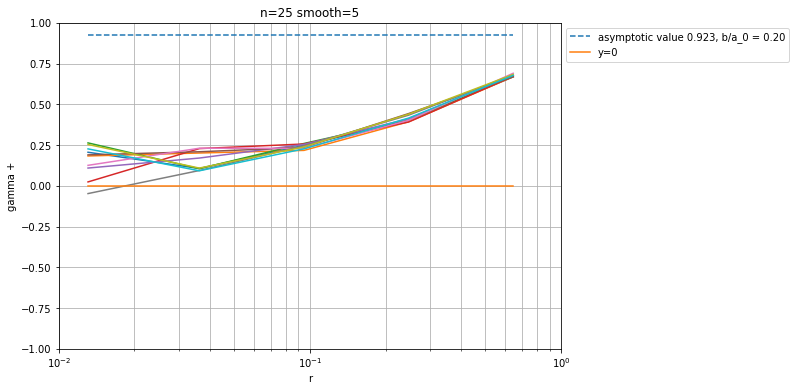

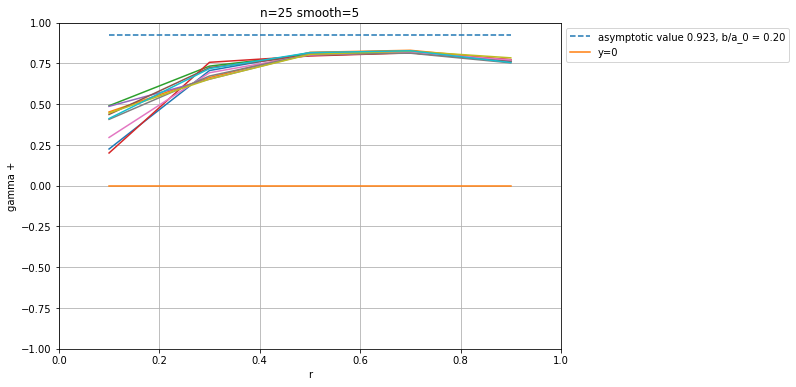

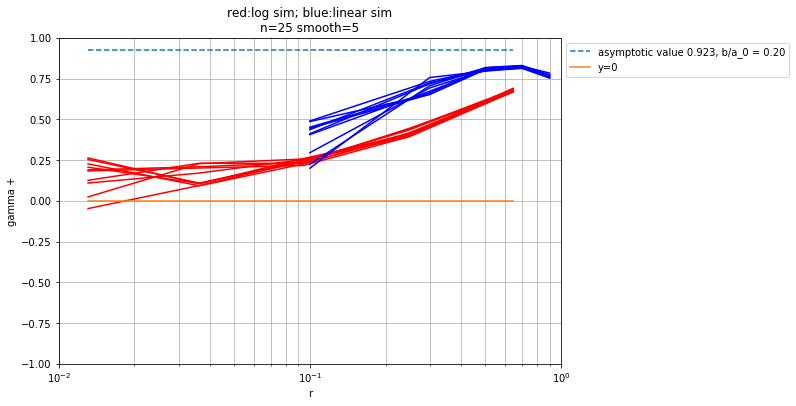

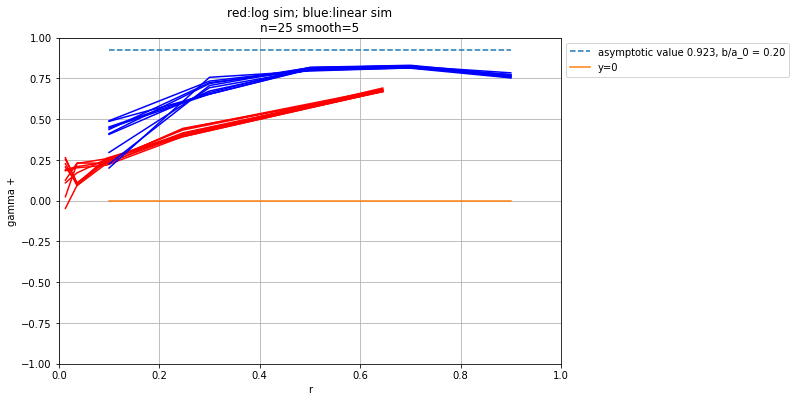

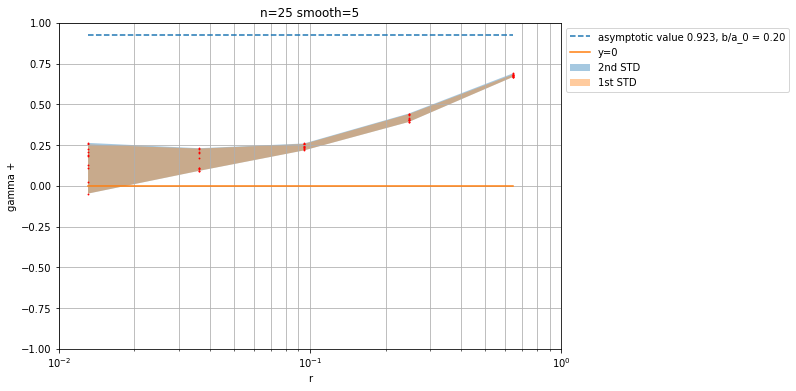

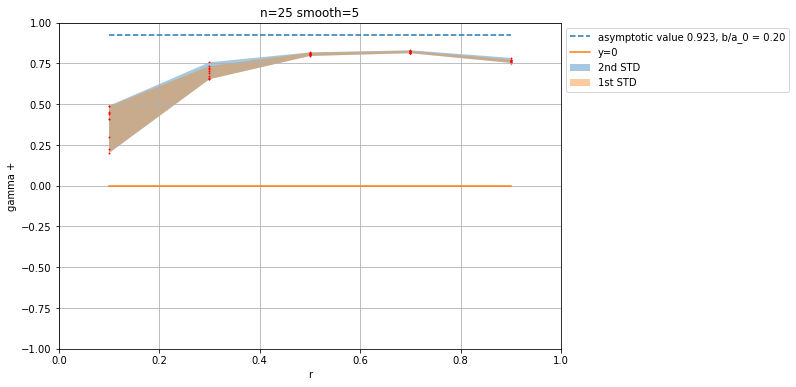

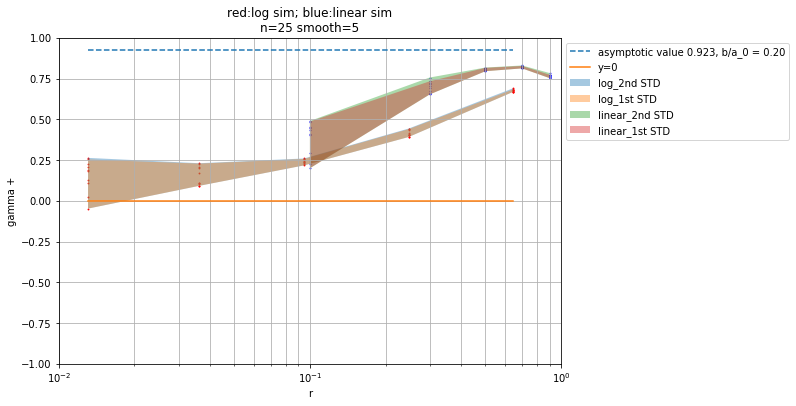

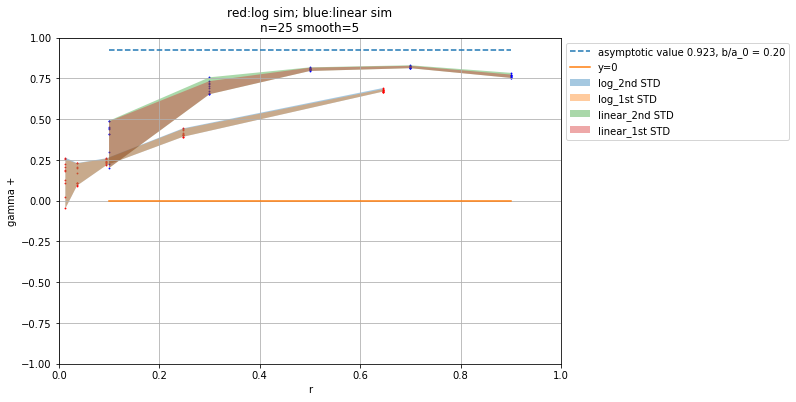

In [3]:
from plot_func import *
outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/tests/log n %i baR_0 %1.2f smr %1.2f'%(n,0.2,np.pi/4)
gamma_base_plot(5,outputpath,'sca');
error_bar_plot(5,outputpath);

In [29]:
#%%writefile [-a] ia_main.py


In [4]:
            
    rs_presmooth = np.linspace(0, R_cut, n+1) #size = n+1
    rs_presmooth = rs_presmooth[0:-1]+(rs_presmooth[0]+rs_presmooth[1])/2 #size = n
    rs = np.array([sum(rs_presmooth[i:i+smoothing_len])/smoothing_len for i in range(0,len(rs_presmooth),smoothing_len)])
        
    #read all the file names in the searchpath folder
    filenames = [f for f in os.listdir(searchpath) if os.path.isfile(os.path.join(searchpath, f))]
    print('rank ',rank,': ',len(filenames),' files discovered')
    
    complete_GamPls = np.empty((0,int(n/smoothing_len)))
    
   
    #get all the gamma data, and smooth them accordingly
    for filename in filenames:
        filepath = os.path.join(searchpath, filename)
        file = open(filepath, "rb")
        gammapls_temp = np.load(file)
        file.close
        
        smoothed_gamma = [sum(gammapls_temp[i:i+smoothing_len])/smoothing_len for i in range(0,len(gammapls_temp),smoothing_len)]
        #now sort each column of the matrix and take the standard deviations
        complete_GamPls = np.vstack((complete_GamPls,smoothed_gamma))
    
    error_GamPls = sort_matrix_columns(complete_GamPls)
    #print(complete_GamPls)
    error_GamPls = get_1_2_std(error_GamPls)
    #print(complete_GamPls)
    error_GamPls = np.vstack((error_GamPls,rs)) #attach the smoothed x coordinate
    #save in the figures folder
    ef.write_file_at_path(outputpath, 'figures',error_GamPls,'STD_With_Radial_Coord_smooth=%i'%smoothing_len)
    
    ### NOW PLOT OVERLAYED SCATTER PLOT + STD ###
    #############################################
    fig = plt.figure(figsize=(9,6))
    for gam in complete_GamPls:
        plt.scatter(rs,gam,c='r',s=0.25,marker='o')
    
    plt.fill_between(rs,error_GamPls[2],error_GamPls[3],alpha = 0.4,label='2nd STD')    
    plt.fill_between(rs,error_GamPls[0],error_GamPls[1],alpha = 0.4,label='1st STD')

    #plt.plot(rs,complete_GamPls[0],label='1st STD')
    #plt.plot(rs,complete_GamPls[1],label='1st STD')
    #plt.plot(rs,complete_GamPls[2],label='2nd STD')
    #plt.plot(rs,complete_GamPls[3],label='2nd STD')
    
    #Plotting reference curves
    asymp = np.array([])
    y_0 = np.zeros(rs.shape)
    for r in rs:
        asymp = np.append(asymp,(1-(baR_0)**2)/(1+(baR_0)**2))

    plt.plot(rs,y_0,label='y=0')
    plt.plot(rs,asymp,"--",label=(
        "asymptotic value %1.3f, b/a_0 = %1.2f" %(
            float((1-(baR_0)**2)/(1+(baR_0)**2)), baR_0)))
    
    if PLOT_LOG_FLAG == True: plt.xscale('log')         
    plt.xlabel('distance')
    plt.ylabel('gamma +')
    plt.title('gamma + vs. normalized R, smoothing=%i'%smoothing_len)
    if PLOT_LOG_FLAG == True: 
        plt.xlim(rs[0],1)
    else: plt.xlim(0,1)
    plt.ylim(-1,1)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    #plt.show()
    imagesavepath = os.path.join(outputpath, 'figures')
    if not os.path.exists(imagesavepath):
        os.makedirs(imagesavepath)
    if PLOT_LOG_FLAG == True: 
        fig.savefig(os.path.join(imagesavepath, 'OVERLAY LOG smoothing = %i'%smoothing_len), bbox_inches = 'tight')  
    else: fig.savefig(os.path.join(imagesavepath, 'OVERLAY smoothing = %i'%smoothing_len), bbox_inches = 'tight')       
    
    
    ######  NOW PLOT JUST STD ########
    ##################################
    fig2 = plt.figure(figsize=(9,6))
    plt.fill_between(rs,error_GamPls[2],error_GamPls[3],alpha = 0.4,label='2nd STD')    
    plt.fill_between(rs,error_GamPls[0],error_GamPls[1],alpha = 0.4,label='1st STD')

    #plt.plot(rs,complete_GamPls[0],label='1st STD')
    #plt.plot(rs,complete_GamPls[1],label='1st STD')
    #plt.plot(rs,complete_GamPls[2],label='2nd STD')
    #plt.plot(rs,complete_GamPls[3],label='2nd STD')
    
    #Plotting reference curves
    plt.plot(rs,y_0,label='y=0')
    plt.plot(rs,asymp,"--",label=(
        "asymptotic value %1.3f, b/a_0 = %1.2f" %(
            float((1-(baR_0)**2)/(1+(baR_0)**2)), baR_0)))
    
    if PLOT_LOG_FLAG == True: plt.xscale('log')         
    plt.xlabel('distance')
    plt.ylabel('gamma +')
    plt.title('gamma + vs. normalized R, smoothing=%i'%smoothing_len)
    if PLOT_LOG_FLAG == True: 
        plt.xlim(rs[0],1)
    else: plt.xlim(0,1)
    plt.ylim(-1,1)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    #plt.show()
    imagesavepath = os.path.join(outputpath, 'figures')
    if not os.path.exists(imagesavepath):
        os.makedirs(imagesavepath)
    if PLOT_LOG_FLAG == True: 
        fig2.savefig(os.path.join(imagesavepath, 'STD LOG smoothing = %i'%smoothing_len), bbox_inches = 'tight')  
    else: fig2.savefig(os.path.join(imagesavepath, 'STD smoothing = %i'%smoothing_len), bbox_inches = 'tight')       
    
###############################################################################################################
########                     Execution code happens below                                              ########
###############################################################################################################
    
n=256
R_cut = 1.0
baR_0 = 0.2
set_condition(n,R_cut,baR_0)
sim_step = 25
offset = 0
PLOT_LOG_FLAG = True

def run_rank(node_index,batch_num,offset): #starting accumulate data at filename = offset.
    #batch number  = 0 or 1. This let the 16 threads to run instead of only 8 cores. 
    #The batch number 2 runs the second copy of the sim steps
    if rank == node_index:
        smr=(np.pi)/8*(rank-size*batch_num/2)
        outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/n%i-baR_0%1.1f-phiSTD%1.2f-thetaSTD%1.2f' %(n,baR_0,rad_to_deg(smr),rad_to_deg(smr))
        searchpath = os.path.join(outputpath,'Gamma_plus')
        
        index_list = np.array(list(range(sim_step)))+(batch_num*sim_step)
        index_list = index_list.astype(int)
        
        for index in index_list:
            print('rank ',rank,': on task ',index+1)
            true_index = index+offset
            get_RA_data(rank,True,true_index,outputpath,n,R_cut,baR_0,smr,smr)
            print('rank ',rank,': tasks ',index+1,' out of ',sim_step*(batch_num+1),' done')
    
        smoothing = 2
        Plot_Gamma_Plus(rank,n,smoothing,baR_0,outputpath,searchpath)
        smoothing = 4
        Plot_Gamma_Plus(rank,n,smoothing,baR_0,outputpath,searchpath)
        
        if batch_num == 1: #the later batch go get error bar
            #Get_Error_Bar(n,1,outputpath,searchpath)
            Get_Error_Bar(n,2,outputpath,searchpath)
            Get_Error_Bar(n,4,outputpath,searchpath)
            #Get_Error_Bar(n,8,outputpath,searchpath)

def run_rank_plots(node_index,batch_num): 
    if rank == node_index:
        if batch_num == 0:
            
            smr=(np.pi)/8*(rank-size*batch_num/2)
            outputpath = '/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/n%i-baR_0%1.1f-phiSTD%1.2f-thetaSTD%1.2f' %(n,baR_0,rad_to_deg(smr),rad_to_deg(smr))
            searchpath = os.path.join(outputpath,'Gamma_plus')
            
            smoothing = 2
            Plot_Gamma_Plus(rank,n,smoothing,baR_0,outputpath,searchpath)
            Get_Error_Bar(n,4,outputpath,searchpath)
            smoothing = 4
            Plot_Gamma_Plus(rank,n,smoothing,baR_0,outputpath,searchpath)
            Get_Error_Bar(n,8,outputpath,searchpath)
            #Get_Error_Bar(n,8,outputpath,searchpath)
"""            
#how ever many slot you want to run:
run_rank(0,0,offset)
run_rank(1,0,offset)
run_rank(2,0,offset)
run_rank(3,0,offset)
run_rank(4,0,offset)
run_rank(5,0,offset)
run_rank(6,0,offset)
time.sleep(5) #this gives time for the previous threads to create directories, etcs.
run_rank(7,1,offset)
run_rank(8,1,offset)
run_rank(9,1,offset)
run_rank(10,1,offset)
run_rank(11,1,offset)
run_rank(12,1,offset)
run_rank(13,1,offset)
run_rank(14,1,offset)"""

run_rank_plots(0,0)
run_rank_plots(1,0)
run_rank_plots(2,0)
run_rank_plots(3,0)
run_rank_plots(4,0)
run_rank_plots(5,0)
run_rank_plots(6,0)
#14 threads gets to ~100%cpu
#n=50 is about 0.9sec/single_run including graphing
#8 cores ~60%cpu
#n=50 is about 1.23sec/single_run including graphing

NameError: name 'set_condition' is not defined

### Setting Functions

file names discovered ['0', '1', '2']


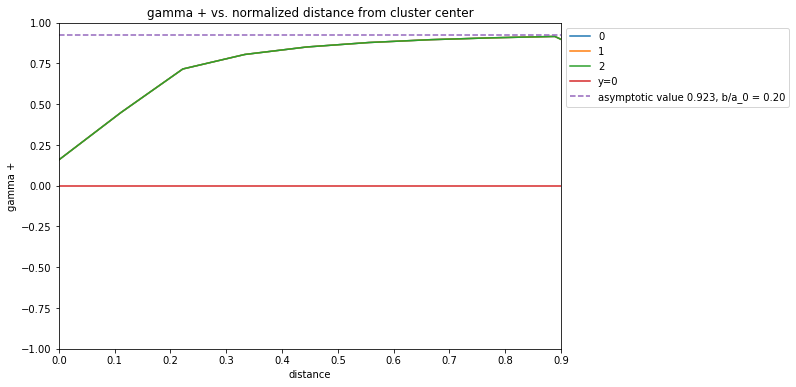

In [15]:
#for index in range(sim_step):
#    smr=0
#    #smr=(np.pi)/8*index
#    #print(smr)

Plot_Gamma_Plus(n,5,baR_0,outputpath,searchpath,'Gamma_Plus_baR=2e-1_smearing,smoothing=5')

In [7]:
p="IA_Numeric_Output/n50-baR_00.2-phiSTD22.50-thetaSTD22.50/figures/STD_With_Radial_Coord_smooth=1"
file = open(p, "rb")
f = np.load(file)
file.close
print(f.shape)

(5, 50)


rank  0 :  28  files discovered


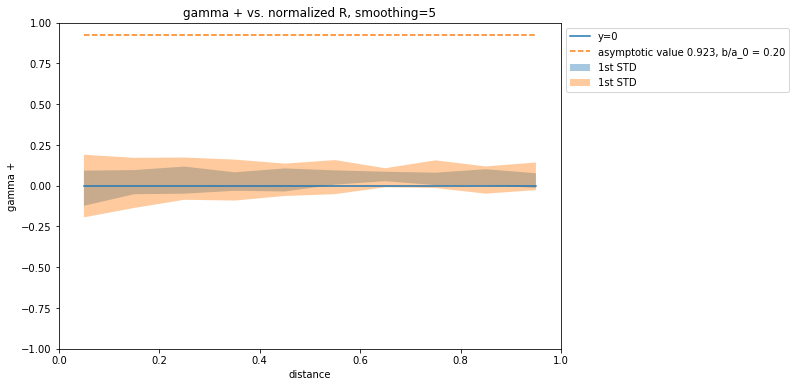

In [35]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
import sys
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#local modules, no name conflicts
from ia_geometry_func import *
from execution_func import *
baR_0 = 0.2
R_cut = 1
outputpath = "/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/n50-baR_00.2-phiSTD90.00-thetaSTD90.00"
searchpath = "/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/n50-baR_00.2-phiSTD90.00-thetaSTD90.00/Gamma_plus smr=90.00"
Get_Error_Bar(50,5,outputpath,searchpath)

In [15]:
#The error bar function
#in each folder of Gamma_plus_some_qualifiers, there are data of multiple runs on the same settinf
#so first we want to navigate to that folder via search_path, and read all the Gamma_plus_files
#This is analogous of the ploting functions above
#This function searches for all the files in a folder. The files should all contain 1-dim np.array. 
#It applies smoothing first, then
#It takes the two lines that signifies the 1 and 2 th STD upper&lower bounds
#and return these 4 lines in one 2-D file that contain both lists.

def Get_Error_Bar(n,smoothing_len,outputpath,searchpath): 
    #outputpath is where the figure folder is saved
    #searchpath is where all the gamma_plus data are stored
    #will save a file, and a plot     
    #[
    #[y value of  std 1 upperbound],
    #[y value of  std 1 lowerbound],
    #[y value of  std 2 upperbound],
    #[y value of  std 2 lowerbound],
    #[smoothed radial coordinate]
    #]

    rs_presmooth = np.linspace(0, R_cut, n+1) #size = n+1
    rs_presmooth = rs_presmooth[0:-1]+(rs_presmooth[0]+rs_presmooth[1])/2 #size = n
    rs = np.array([sum(rs_presmooth[i:i+smoothing_len])/smoothing_len for i in range(0,len(rs_presmooth),smoothing_len)])
        
    #read all the file names in the searchpath folder
    filenames = [f for f in os.listdir(searchpath) if os.path.isfile(os.path.join(searchpath, f))]
    print('rank ',rank,': ',len(filenames),' files discovered')
    
    complete_GamPls = np.empty((0,int(n/smoothing_len)))
    
    fig= plt.figure(figsize=(9,6))
    #get all the gamma data, and smooth them accordingly
    for filename in filenames:
        filepath = os.path.join(searchpath, filename)
        file = open(filepath, "rb")
        gammapls_temp = np.load(file)
        file.close
        
        smoothed_gamma = [sum(gammapls_temp[i:i+smoothing_len])/smoothing_len for i in range(0,len(gammapls_temp),smoothing_len)]
        #now sort each column of the matrix and take the standard deviations
        complete_GamPls = np.vstack((complete_GamPls,smoothed_gamma))
    
    complete_GamPls = sort_matrix_columns(complete_GamPls)
    #print(complete_GamPls)
    complete_GamPls = get_1_2_std(complete_GamPls)
    #print(complete_GamPls)
    complete_GamPls = np.vstack((complete_GamPls,rs))
    #save in the figures folder
    ef.write_namedfile_at_path(outputpath, 'figures',complete_GamPls,'STD_With_Radial_Coord_smooth=%i'%smoothing_len)
    
    plt.fill_between(rs,complete_GamPls[2],complete_GamPls[3],alpha = 0.4,label='2nd STD')    
    plt.fill_between(rs,complete_GamPls[0],complete_GamPls[1],alpha = 0.4,label='1st STD')

    #plt.plot(rs,complete_GamPls[0],label='1st STD')
    #plt.plot(rs,complete_GamPls[1],label='1st STD')
    #plt.plot(rs,complete_GamPls[2],label='2nd STD')
    #plt.plot(rs,complete_GamPls[3],label='2nd STD')
    
    #Plotting reference curves
    asymp = np.array([])
    y_0 = np.zeros(rs.shape)
    for r in rs:
        asymp = np.append(asymp,(1-(baR_0)**2)/(1+(baR_0)**2))

    plt.plot(rs,y_0,label='y=0')
    plt.plot(rs,asymp,"--",label=(
        "asymptotic value %1.3f, b/a_0 = %1.2f" %(
            float((1-(baR_0)**2)/(1+(baR_0)**2)), baR_0)))
        
        
    plt.xlabel('distance')
    plt.ylabel('gamma +')
    plt.title('gamma + vs. normalized R, smoothing=%i'%smoothing_len)
    plt.xlim(0,1)
    plt.ylim(-1,1)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.show()
    imagesavepath = os.path.join(outputpath, 'figures')
    if not os.path.exists(imagesavepath):
        os.makedirs(imagesavepath)
    fig.savefig(os.path.join(imagesavepath, 'STD'), bbox_inches = 'tight')   

In [23]:
import numpy as np
R_cut = 1.0
n=10
smoothing_len = 2
print(np.linspace(0, R_cut, int(n)))
print([1,2,3,4,5,6,1,2,3,4])
print(np.linspace(0, R_cut, int(n/smoothing_len)))
gammapls_temp = [1,2,3,4,5,6,1,2,3,4]
print([sum(gammapls_temp[i:i+smoothing_len])/smoothing_len for i in range(0,len(gammapls_temp),smoothing_len)])
[sum(np.linspace(0, R_cut, int(n))[i:i+smoothing_len])/smoothing_len for i in range(0,len(np.linspace(0, R_cut, int(n))),smoothing_len)]


[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
[1, 2, 3, 4, 5, 6, 1, 2, 3, 4]
[0.   0.25 0.5  0.75 1.  ]
[1.5, 3.5, 5.5, 1.5, 3.5]


[0.05555555555555555,
 0.2777777777777778,
 0.5,
 0.7222222222222221,
 0.9444444444444444]

In [19]:
file = open('/home/azhou/IA-Sim-AZhou00/IA_Numeric_Output/n50-baR_00.2-phiSTD22.50-thetaSTD22.50/Gamma_plus smr=22.50/1', "rb")
gammapls_temp = np.load(file)

In [20]:
print(gammapls_temp)

[0.         0.90800467 0.         0.64173886 0.9069052  0.87641276
 0.         0.8849552  0.81004651 0.87150571 0.87614419 0.84115608
 0.83777602 0.84882697 0.86484253 0.8476959  0.85291321 0.84222393
 0.8577222  0.85007012 0.86245756 0.85921927 0.86680435 0.85706828
 0.86242994 0.86871882 0.86216892 0.86990024 0.86582496 0.8694357
 0.8730809  0.87933607 0.87746278 0.87640168 0.88251177 0.88527401
 0.88764863 0.89002999 0.89252354 0.89415945 0.89513982 0.89833868
 0.90127236 0.89466135 0.89853674 0.89546503 0.89071047 0.89035001
 0.86499291 0.        ]
